In [1]:
import tensorflow as tf
from IPython.display import Image
import numpy as np
import pickle as pkl
import os
from tensorflow.keras.layers import *
from tensorflow.python.ops import init_ops
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
with open('./output/train_input.pkl', 'rb') as f:
    train_input = pkl.load( f)
with open('./output/train_output.pkl', 'rb') as f:
    train_output=pkl.load( f)
with open('./output/val_input.pkl', 'rb') as f:
    val_input=pkl.load(f)
with open('./output/val_output.pkl', 'rb') as f:
    val_output=pkl.load(f)
with open('./output/test_input.pkl', 'rb') as f:
    test_input=pkl.load(f)
with open('./output/test_output.pkl', 'rb') as f:
    test_output=pkl.load(f)
with open('./output/inp_w2i.pkl', 'rb') as f:
    inp_word2idx=pkl.load(f)
with open('./output/inp_i2w.pkl', 'rb') as f:
    inp_idx2word=pkl.load(f)
with open('./output/oup_w2i.pkl', 'rb') as f:
    oup_word2idx=pkl.load(f)
with open('./output/oup_i2w.pkl', 'rb') as f:
    oup_idx2word=pkl.load(f)
    
with open('./input_matrix.pkl', 'rb') as f:
    inp_matrix = pkl.load(f)
with open('./output_matrix.pkl', 'rb') as f:
    oup_matrix = pkl.load(f)

In [3]:
input_vocab_size = len(inp_idx2word)
target_vocab_size = len(oup_word2idx)

In [4]:
hidden_dim = 512
num_layers = 3
dropout_ratio = 0.1
BATCH_SIZE = 128
Epochs = 20

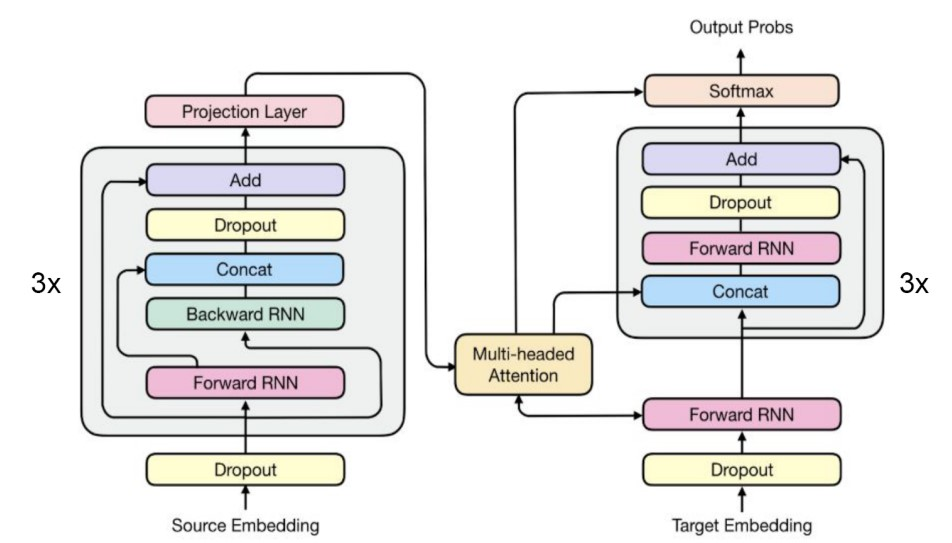

In [5]:
Image('img.jpg')

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, dropout_ratio):
        super(EncoderLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.bi_lstm = Bidirectional(LSTM(hidden_dim//2 , return_sequences = True, return_state=True), merge_mode = 'concat')
        self.dropout = Dropout(rate=dropout_ratio)
        
    def call(self, x, hidden_state):
        bi_lstm_output, state_h_f, state_c_f, state_h_b, state_c_b = self.bi_lstm(x, initial_state = hidden_state)
#         state_h_f : forward LSTM hidden state
#         state_c_f : forward LSTM cell state
#         state_h_b : backward LSTM hidden state
#         state_c_b : backward LSTM cell state
        hidden_state = Concatenate()([state_h_f,state_h_b])
        cell_state = Concatenate()([state_c_f, state_c_b])
        
        dropout_output = self.dropout(bi_lstm_output)
        
        add_output = x + dropout_output
        return add_output, hidden_state, cell_state

(Concat) Bidirrectional LSTM Hidden state dimension : hidden_state // 2  
initial state : (batch size, hidden_state // 2), 
                (batch size, hidden_state // 2), 
                (batch size, hidden_state // 2), 
                (batch size, hidden_state // 2)

In [7]:
example_input = tf.ones(shape = (256, 30 ,hidden_dim))
encoder_layer = EncoderLayer(hidden_dim, dropout_ratio)
initial_state = tf.zeros(shape = (256, hidden_dim//2))
initial_state = [initial_state, initial_state, initial_state, initial_state]
encoder_output, _, _  = encoder_layer(example_input, initial_state)
print("Example input shape :", example_input.shape)
print("Encoder Layer output shape :", encoder_output.shape)

Example input shape : (256, 30, 512)
Encoder Layer output shape : (256, 30, 512)


In [8]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, num_layers, embedding_dimension, hidden_dimension, dropout_ratio):
        super(Encoder, self).__init__()
        if embedding_dimension // hidden_dimension != 2:
            assert 'Embedding dimension have to twice hidden size.'
        self.num_layers = num_layers
        self.hidden_dim = hidden_dimension
        self.output_dim = self.hidden_dim
        self.embedding = Embedding(input_vocab_size, embedding_dimension)
        self.dropout = Dropout(dropout_ratio)
        self.encoder_layers = [EncoderLayer(self.hidden_dim, dropout_ratio) for _ in range(num_layers)]
        self.projeciton_layer = Dense(self.output_dim, activation = 'linear')
        
    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.dropout(x)
        hidden_state_list = []
        for i in range(num_layers):
            enc_output, hidden_state, cell_state = self.encoder_layers[i](x, hidden)
            hidden_state_list.append([hidden_state, cell_state])
        # calcualate encoder layer
        
        enc_output = self.projeciton_layer(enc_output)
        # linear activation layer(projection layer) 
        return enc_output, hidden_state_list
    
    def make_initial_state(self, batch_size):
        zero_state = tf.zeros(shape = (batch_size, self.hidden_dim//2))
        return [zero_state, zero_state, zero_state, zero_state]

In [9]:
encoder = Encoder(len(inp_idx2word), 3, hidden_dim  , hidden_dim, dropout_ratio)
initial_state = encoder.make_initial_state(256)
encoder_output,hidden_state= encoder(train_input[:256], initial_state)
print('hidden_state_length :', len(hidden_state),
      '\nhidden_state shpae :', hidden_state[0][0].shape,
      '\ncell_state length :', len(hidden_state),
      '\ncell_state shape :', hidden_state[0][0].shape)

hidden_state_length : 3 
hidden_state shpae : (256, 512) 
cell_state length : 3 
cell_state shape : (256, 512)


In [10]:
class MultiHead_Addictive(tf.keras.layers.Layer):
    def __init__(self, head_num, dimension, use_scale = True):
        super(MultiHead_Addictive, self).__init__()
        self.head_num = head_num
        self.use_scale = use_scale
        if self.use_scale:
            self.scale = self.add_weight(shape = [dimension//head_num],
                                        initializer= init_ops.glorot_uniform_initializer(),
                                        trainable=True,
                                        dtype = self.dtype)
        else:
            self.scale = None
        # define scale value
        
    def split_head(self, query, key):
        batch_size = query.shape[0]
        # define batch_size
        
        query_length = query.shape[1]
        key_length = key.shape[1]
        # define data length
    
        query = tf.reshape(query, shape = (batch_size, query_length, self.head_num, -1))
        key = tf.reshape(key, shape =  (batch_size, key_length, self.head_num, -1))
        
        query = tf.transpose(query, perm=[0,2,1,3])
        key = tf.transpose(key, perm = [0,2,1,3])
        # split head
        return query, key
    
    def AdditiveAttention(self, query, key):
        if self.use_scale:
            attention_value = tf.reduce_sum(tf.tanh(query + key), axis = -1)
            print('attehtion_value.shape', attention_value.shape)
        else:
            attention_value = tf.reduce_sum(tf.tanh(query + key), axis = -1)
            
        attention_value = tf.expand_dims(attention_value, axis = -1)
        context_value = attention_value * query
        print("Head context vector shape :",context_value.shape)
        return context_value
    
    def call(self, query, key):
        query, key = self.split_head(query, key)
        multihead_output = []
        for i in range(self.head_num):
            multihead_output.append(self.AdditiveAttention(query[::,i], key[::, i]))
        multihead_output = Concatenate()(multihead_output)
        multihead_output = tf.expand_dims(tf.reduce_sum(multihead_output, axis=1), axis = 1)
        
        return multihead_output

In [11]:
multihaad = MultiHead_Addictive(4, 300)
value = tf.zeros(shape = (128,30,300))+tf.zeros(shape = (128,1,300))
multihead_output = multihaad(tf.ones(shape = (128,30,300)), tf.ones(shape = (128,1,300)))
print("\nAttention output :",multihead_output.shape)

attehtion_value.shape (128, 30)
Head context vector shape : (128, 30, 75)
attehtion_value.shape (128, 30)
Head context vector shape : (128, 30, 75)
attehtion_value.shape (128, 30)
Head context vector shape : (128, 30, 75)
attehtion_value.shape (128, 30)
Head context vector shape : (128, 30, 75)

Attention output : (128, 1, 300)


In [12]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, dropout_ratio):
        super(DecoderLayer, self).__init__()
        self.concat = Concatenate()
        self.lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
        self.dropout = Dropout(dropout_ratio)
        
    def call(self, x, context_vector, state):
        concat_output = self.concat([x, context_vector])
        lstm_output, h_state, c_state = self.lstm(concat_output, initial_state = state)
#         print(lstm_output.shape)
        lstm_output = self.dropout(lstm_output)
        add_output = lstm_output + x
        return add_output, h_state, c_state

In [13]:
example_input = tf.ones(shape = (128,1,300))
example_context_vector = tf.ones(shape = (128,1,300)) 
state = [tf.zeros((128, 300)),tf.zeros((128, 300))]

decoder_layer = DecoderLayer(300, 0.1)

dec_output, h_state, c_state = decoder_layer(example_input, example_context_vector, state)

print('Example input shape :', example_input.shape)
print("Example context vector shape :", example_context_vector.shape)

print("Decoder Layer output.shape", dec_output.shape)

Example input shape : (128, 1, 300)
Example context vector shape : (128, 1, 300)
Decoder Layer output.shape (128, 1, 300)


In [14]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, target_vocab_size, embedding_dim, head_num, num_layers, hidden_dim, dropout_value):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        
        self.embedding = Embedding(target_vocab_size, embedding_dim)
        self.lstm = LSTM(hidden_dim, return_sequences = True, return_state = True)
        self.dropout = Dropout(dropout_ratio)
        self.multihead_attention = MultiHead_Addictive(head_num, hidden_dim)
        self.decoder_layers = [DecoderLayer(hidden_dim, dropout_value) for _ in range(num_layers)]
        self.output_dense = Dense(target_vocab_size)
    
    def call(self, x, encoder_output, lstm_state, layer_state):
        x = self.embedding(x)
        dropout_x = self.dropout(x)
        
        context_vector =  self.multihead_attention(encoder_output, tf.expand_dims(lstm_state[0], axis = -2))
        print('dropout_x.shape', dropout_x.shape)
        print('context_vector.shape', context_vector.shape)
#         get context vector
        lstm_input = Concatenate()([dropout_x, context_vector])
#         lstm_input : concatenate( embedding_value , context_vector)
        print(lstm_state[0].shape, lstm_state[1].shape)
        lstm_output, lstm_hidden_state, lstm_cell_state = self.lstm(lstm_input, initial_state = lstm_state)
#         initialstate : add output(encoder lstm output)
        new_lstm_state = [lstm_hidden_state, lstm_cell_state]
#         new initial state : lstm_hidden_state, lstm_cell_state

        new_layer_state = []
        for i in range(self.num_layers):
            f_lstm_input = lstm_output
            f_lstm_input, hidden, cell = self.decoder_layers[i](f_lstm_input, context_vector, layer_state[i])
            new_layer_state.append([hidden, cell])
        print('lstm_output : ', f_lstm_input.shape)
        output = self.output_dense(f_lstm_input)
        print(output.shape)
        return output, new_lstm_state, new_layer_state

In [16]:
decoder = Decoder(target_vocab_size = target_vocab_size, 
                  embedding_dim = 300, 
                  head_num = 4, 
                  num_layers = 3, 
                  hidden_dim = 512, 
                  dropout_value = 0.1)

example_target_input = train_output[:128, :1]
encoder_output = tf.ones(shape =  (128,32,512))
lstm_state = [tf.zeros((128, 512)), tf.zeros((128, 512))]
layer_state = [lstm_state, lstm_state, lstm_state]

output, new_lstm_state, new_layer_state = decoder(example_target_input, encoder_output, lstm_state, layer_state)

output.shape

attehtion_value.shape (128, 32)
Head context vector shape : (128, 32, 128)
attehtion_value.shape (128, 32)
Head context vector shape : (128, 32, 128)
attehtion_value.shape (128, 32)
Head context vector shape : (128, 32, 128)
attehtion_value.shape (128, 32)
Head context vector shape : (128, 32, 128)
dropout_x.shape (128, 1, 300)
context_vector.shape (128, 1, 512)
(128, 512) (128, 512)
lstm_output :  (128, 1, 512)
(128, 1, 244881)


TensorShape([128, 1, 244881])

In [17]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [18]:
learning_rate = CustomSchedule(hidden_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')


In [19]:
def loss_function(real, pred):
	mask = tf.math.logical_not(tf.math.equal(real, 0))
	loss_ = loss_object(real, pred)

	mask = tf.cast(mask, dtype=loss_.dtype)
	loss_ *= mask

	return tf.reduce_mean(loss_)

In [20]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

In [20]:
def train_step(inp, tar, encoder_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, hidden_state = encoder(inp, encoder_hidden)
        dec_lstm_state = [(hidden_state[0][0] + hidden_state[1][0] + hidden_state[2][0])/3,
                          (hidden_state[0][1] + hidden_state[1][1] + hidden_state[2][1])/3]
        
        print(dec_lstm_state[0].shape, dec_lstm_state[1].shape)
        target_token = tf.expand_dims(tar[:, 0], 1)
        for t in range(1, tar.shape[1]):
            predictions, dec_lstm, dec_layer_lstm = decoder(target_token,
                                                            enc_output,
                                                            dec_lstm_state,
                                                            hidden_state)
            loss += loss_function(tar[:, t], predictions)    
            dec_input = tf.expand_dims(tar[:, t] , 1)
        batch_loss = (loss/int(tar.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss        